# Wasserstein Generative Adversarial Network
This notebook implements Wasserstein Generative Adversarial Network. It is just for exploring the concept rather than aiming for a good results.

This is inspired by Dr Jorge Cardoso's lecture at King's College London.

## Import general library and define common structure

In [2]:
# Import library and set up environment
import os as os
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = torch.cuda.device_count()
print("Number of GPU workers available:", num_workers)

cuda
Number of GPU workers available: 2


## Load the dataset

In [3]:
# Set the directory path
directory = './data'
# Load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])
training = torchvision.datasets.MNIST(root=directory, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(training, batch_size=32, shuffle=True, num_workers=2)
# Create dataloader
testing = torchvision.datasets.MNIST(root=directory, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testing, batch_size=32, shuffle=False, num_workers=2)
# Label the classes
classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')
# List all files in the directory
files = os.listdir(directory)
# Print the file names
for file in files:
    print(file)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37377977.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1047805.05it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8320069.53it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5588304.13it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

MNIST


## Define some basic network block

In [ ]:
# Define a resdidual block t
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, mode="level"):
    '''
      in_channels - integer - the number of feature channels the first
                              convolution will receive
      out_channels - integer - the number of feature channels the last
                               convolution will output
      mode - string - defines what the block will do
           - "upsample" means the block wil double the spatial size
           - "downsample" means the block will halve the spatial size
           - "level" means the block will not change the spatial dimension
    '''
    super(ResBlock, self).__init__()
    if mode == "upsample":
      self.main_forward = nn.Sequential(
          nn.ConvTranspose2d(
              in_channels=in_channels,
              out_channels=out_channels,
              kernel_size=4,
              stride=2,
              padding=1,
          ),
          nn.LeakyReLU(inplace=True),
          nn.Conv2d(
              in_channels=out_channels,
              out_channels=out_channels,
              kernel_size=3,
              stride=1,
              padding=1,
          ),         
      )
      self.residual_forward = nn.ConvTranspose2d(
          in_channels=in_channels,
          out_channels=out_channels,
          kernel_size=4,
          stride=2,
          padding=1,
      )
    else:
      self.main_forward = nn.Sequential(
          nn.Conv2d(
              in_channels=in_channels,
              out_channels=out_channels,
              kernel_size=3,
              stride=2 if mode == "downsample" else 1,
              padding=1,
          ),
          nn.LeakyReLU(inplace=True),
          nn.Conv2d(
              in_channels=out_channels,
              out_channels=out_channels,
              kernel_size=3,
              stride=1,
              padding=1,
          ),         
      )
      self.residual_forward = nn.Conv2d(
          in_channels=in_channels,
          out_channels=out_channels,
          kernel_size=3,
          stride=2 if mode == "downsample" else 1,
          padding=1,
      )
#     self.activation = nn.LeakyReLU(inplace=True)
  def forward(self, x):
    out = self.main_forward(x)
    x = out + self.residual_forward(x)
    return F.leaky_relu(x)

# Test
test = ResBlock(1, 3, "level")
x = torch.rand((100, 1, 28, 28))
print(x.size())
print(test(x).size())

torch.Size([100, 1, 28, 28])
torch.Size([100, 3, 28, 28])


In [5]:
# Define a multilayer perceptron
class MLP(nn.Module):
    def __init__(self, *number_of_features):
        super(MLP, self).__init__()
        # Dict that store the layers
        linear_dict = OrderedDict()
        i = -1
        for i in range(len(number_of_features) - 2):
            linear_dict[f"Linear_layer_{i+1}"] = nn.Linear(
                in_features = number_of_features[i],
                out_features = number_of_features[i+1],
            )
            linear_dict[f"Batchnorm_{i}"] = nn.BatchNorm1d(
                num_features = number_of_features[i+1],
                momentum = 0.8,
            )
            linear_dict[f"Relu_{i}"] = nn.LeakyReLU()
        i+=1
        # Last layer
        linear_dict[f"Linear_layer_{i+1}"] = nn.Linear(
            in_features = number_of_features[i],
            out_features = number_of_features[i+1],
        )
        # Combine into one        
        self.all_linear = nn.Sequential(linear_dict)
    def forward(self, x):
        return self.all_linear(x)

# Test
test = MLP(*[128, 256, 512, 1024])

x = torch.rand((100, 128))
print(x.size())
print(test(x).size())

torch.Size([100, 128])
torch.Size([100, 1024])


# WGAN network with Gradient Penalty
The network train the discriminator to maximize the Wasserstein and generator to minimize it.

Gradient Penalty help the discriminator output do not skyrocket to infinity


torch.Size([100, 100])
torch.Size([100, 1, 28, 28])


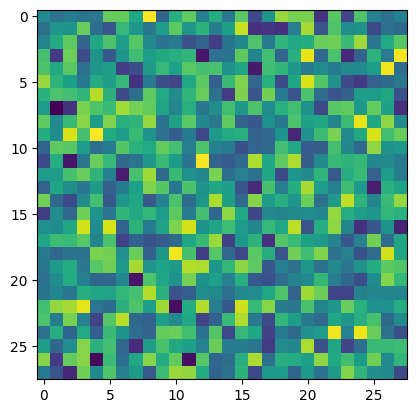

In [65]:
class Generator(nn.Module):
    def __init__(self, in_features = 100, hidden_features = [128, 256, 512, 1024], img_size = (28, 28)):
        super(Generator, self).__init__()

        hidden_features.append(np.prod(img_size))
        self.model = nn.Sequential(
            nn.Linear(
                in_features = in_features,
                out_features = hidden_features[0]
            ),
            nn.LeakyReLU(),
            MLP(*hidden_features),
            nn.Tanh()
        )
        # Store the size
        self.img_size = img_size

    def forward(self, z):
        z = self.model(z)
        z = z.view(z.shape[0], 1, *self.img_size)
        return z
# Test
in_features = 100
hidden_features = [128, 256, 512, 1024]
img_size = (28, 28)
test = Generator(in_features, hidden_features, img_size)

x = torch.rand((100, in_features))
print(x.size())
print(test(x).size())
plt.imshow(test(x)[0,0,:,:].detach().numpy())

In [67]:
class Discriminator(nn.Module):
    def __init__(self, hidden_features = [512, 256, 1], img_size = (28, 28)):
        super(Discriminator, self).__init__()
        
        hidden_features.insert(0, int(np.prod(img_size)/4))
        self.model = nn.Sequential(
            ResBlock(
                in_channels = 1,
                out_channels = 2,
                mode = "downsample"
            ),
            ResBlock(
                in_channels = 2,
                out_channels = 4,
                mode = "downsample"
            ),
            nn.Flatten(start_dim = 1),
            MLP(*hidden_features),
        )

    def forward(self, img):
        validity = self.model(img)
        return validity
    
hidden_features = [512, 256, 1]
img_size = (28, 28)
test = Discriminator(hidden_features, img_size)

x = torch.rand((100, 1, *img_size))
print(x.size())
print(test(x).size())
# plt.imshow(test(x)[0,:,:].detach().numpy())

torch.Size([100, 1, 28, 28])
torch.Size([100, 1])


In [79]:
torch.tensor(np.random.random((1, 1, 1, 1),)).to(device)

tensor([[[[0.8297]]]], device='cuda:0', dtype=torch.float64)

In [84]:
lambda_gp = 10

def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    # Calcualte interpolated samples
    alpha = torch.rand(((real_samples.size(0), 1, 1, 1))).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)

    d_interpolates = discriminator(interpolates)
    fake = torch.ones((real_samples.size(0),1)).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)

    # Calculate the gradient penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

In [68]:
loss_func = nn.BCELoss()

# Test
latent_features = 50
hidden_features_G = [128, 256, 512, 1024, 2048]
hidden_features_D = [512, 256, 1]
img_size = (28, 28)

generator = Generator(latent_features, hidden_features_G, img_size)
discriminator = Discriminator(hidden_features_D, img_size)


generator.to(device)
discriminator.to(device)
loss_func.to(device)

lr = 0.001
b1 = 0.9
b2 = 0.999
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))


In [88]:
lamda_gp = 10
def train(generator, discriminator, optimizer_G, optimizer_D, loss_func, num_epochs = 1):
    generator.train()
    discriminator.train()
    loss_list = []
    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(train_loader, 0):
            # Vector to compare to output
            valid = torch.ones((imgs.size(0),1)).to(device)
            fake = torch.zeros((imgs.size(0),1)).to(device)
            # Push data to GPU, clear gradient, calculate loss, backpropagation
            imgs = imgs.to(device)
            labels = labels.to(device)
            # Zero gradient
            optimizer_G.zero_grad()
            # Sample noise 
            z = torch.rand(imgs.size(0), latent_features).to(device)
            # Forward
            fake_imgs = generator(z)
            # Calculate the loss
            loss_G = -discriminator(fake_imgs).mean()
            # Calculate the gradient
            loss_G.backward()
            # Update the weight
            optimizer_G.step()

            # Zero gradient
            optimizer_D.zero_grad()
            fake_imgs = fake_imgs.detach()
            # Calculate the loss
            loss_D = discriminator(fake_imgs).mean() - discriminator(imgs).mean() + lamda_gp * compute_gradient_penalty(discriminator, imgs.data, fake_imgs.data)
            # Calculate the gradient
            loss_D.backward()
            # Update the weight
            optimizer_D.step()          
            
            # Store the loss value
            loss_list.append([loss_G.item(), loss_D.item()])

            # print the loss
            if i % 1000 == 0:
                print(f"Epoch: {epoch}/{num_epochs}; Data {i*len(labels)}/{len(train_loader.dataset)}; Loss G: {loss_G.item()}; Loss D: {loss_D.item()}")
    return loss_list

loss = train(generator, discriminator, optimizer_G, optimizer_D, loss_func, num_epochs = 1)

Epoch: 0/1; Data 0/60000; Loss G: -7.067683219909668; Loss D: 5.271590232849121
Epoch: 0/1; Data 32000/60000; Loss G: -5.057155609130859; Loss D: -3.3742804527282715


In [91]:
loss = train(generator, discriminator, optimizer_G, optimizer_D, loss_func, num_epochs = 30)

Epoch: 0/30; Data 0/60000; Loss G: -7.916162014007568; Loss D: -17.77688217163086
Epoch: 0/30; Data 32000/60000; Loss G: 2.3547511100769043; Loss D: -22.104747772216797
Epoch: 1/30; Data 0/60000; Loss G: 12.984017372131348; Loss D: -25.262813568115234
Epoch: 1/30; Data 32000/60000; Loss G: 31.352489471435547; Loss D: -78.66181182861328
Epoch: 2/30; Data 0/60000; Loss G: 14.191736221313477; Loss D: 21.078598022460938
Epoch: 2/30; Data 32000/60000; Loss G: -8.917335510253906; Loss D: -20.79961395263672
Epoch: 3/30; Data 0/60000; Loss G: -15.123046875; Loss D: -43.583492279052734
Epoch: 3/30; Data 32000/60000; Loss G: -23.571447372436523; Loss D: -31.59078598022461
Epoch: 4/30; Data 0/60000; Loss G: -10.417585372924805; Loss D: -47.187583923339844
Epoch: 4/30; Data 32000/60000; Loss G: -33.933326721191406; Loss D: -10.232606887817383
Epoch: 5/30; Data 0/60000; Loss G: -30.381811141967773; Loss D: -39.383544921875
Epoch: 5/30; Data 32000/60000; Loss G: -21.994417190551758; Loss D: -39.5474